<a href="https://colab.research.google.com/github/keisuke6616/CDM/blob/master/Figure4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Next, Yata and Aoshima considered a non-Gaussian case.

Independent pseudorandom normal observations were generated from a d-variate t-distribution, $t_d({\bf 0}, {\bf \Sigma}, {\nu})$ with ${\nu}$ = 15 and ${\bf \Sigma}$ have $\lambda_1 = d^{2/3}$, $\lambda_2 = d^{1/3}$ and $\lambda_3, \ldots, \lambda_d = 1$ as eigenvalue in power spiked model. They fixed the sample size as n = 60 and set the distribution as d = 1000(200)2000.
They compered with ${\tilde \lambda}$ and ${\hat \lambda}$, where ${\tilde \lambda}$ and ${\hat \lambda}$ are the estimation of $\lambda$ by using the cross-data-methodology and using dual matrix respectively.



In [0]:
import numpy as np

import matplotlib.pyplot as plt

import time

# Figure4

In [0]:
t1 = time.time()
np.random.seed(42)

N = 60
df = 15
D = [1000 + 200 * i for i in range(6)]
index = [i for i in range(len(D))]
fnc = function()

iter = 1000
result = np.zeros((len(D), 2, 2))

for d, pc in zip(D, index):
    print('Dimension : {}'.format(d))
    eig = np.array([d**(2/3), d**(1/3)] + [1 for i in range(d - 2)])
    Sigma = (df - 2) / df * np.diag(eig)
    value, vec = fnc.eig_sort(Sigma)
    Gamma = np.sqrt(value).reshape(-1, d) * vec
    
    
    for l in range(iter):
        Z = np.random.normal(0, 1, (N, d))
        rd_chi = np.random.chisquare(df, N).reshape(N, -1)
        X = np.dot(Z, Gamma.T) / np.sqrt(rd_chi / df)
        
        fnc.data(X, bias=True)
        
        for i in range(2):
            result[pc, 0, i] += fnc.dual_value()[i] / iter
            result[pc, 1, i] += fnc.CDM_value()[i] / iter
            
 
    
    print('Mean')
    print('Dual : {}'.format(result[pc, 0]))
    print('CDM : {}'.format(result[pc, 1]))
    print('True : {}'.format(eig[:2]))
    print('')
    

t2 = time.time()
print('Calculation time : {}'.format(t2-  t1))
                
        
        
        
        

    

Dimension : 1000
Mean
Dual : [121.04946486  44.54507882]
CDM : [98.71716273 13.68012459]
True : [100.  10.]

Dimension : 1200
Mean
Dual : [137.76111213  53.47752993]
CDM : [110.60231638  14.74799182]
True : [112.92432347  10.62658569]

Dimension : 1400
Mean
Dual : [155.06418148  61.00236883]
CDM : [123.79576852  15.83997106]
True : [125.14649491  11.18688942]

Dimension : 1600
Mean
Dual : [170.9193965   69.21354373]
CDM : [135.43880372  16.88468904]
True : [136.79807573  11.69607095]

Dimension : 1800
Mean
Dual : [185.31877364  77.610491  ]
CDM : [145.06477167  17.74138687]
True : [147.97272446  12.16440399]

Dimension : 2000
Mean
Dual : [199.20145269  85.49912218]
CDM : [154.82401615  18.61131656]
True : [158.7401052  12.5992105]



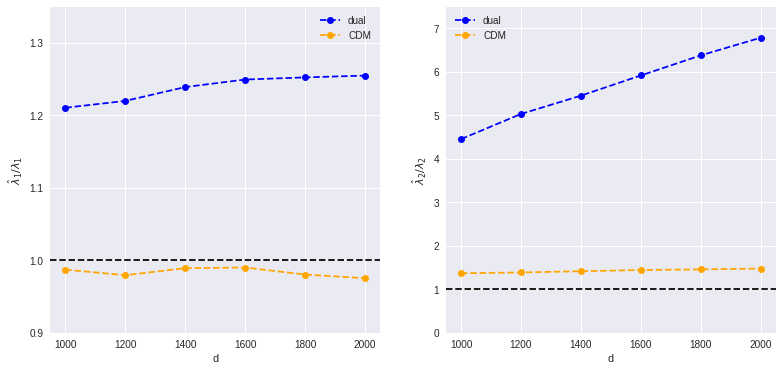

In [0]:
lmd_div = np.zeros((len(D), 2, 2))
for d, pc in zip(D, index):
    eig = [d**(2/3), d**(1/3)]
    for i in range(2):
        lmd_div[pc, :, i] = result[pc, :, i] / eig[i]

color_list = ['blue', 'orange']
label_list = ['dual', 'CDM']
lim = [(0.9, 1.5), (0, 8)]

plt.figure(figsize=(13, 6))

plt.subplot(121)
for i in range(2):
    plt.plot(D, lmd_div[:, i, 0],'o--', color=color_list[i], label=label_list[i])
plt.axhline(y=1, color='black', linestyle='dashed')
plt.ylim(0.9, 1.35)
plt.ylabel('${\hat \lambda}_1 / \lambda_1$')
plt.xlabel('d')
plt.legend()

plt.subplot(122)
for i in range(2):
    plt.plot(D, lmd_div[:, i, 1], 'o--', color=color_list[i], label=label_list[i])
plt.axhline(y=1, color='black', linestyle='dashed')
plt.ylim(0, 7.5)
plt.ylabel('${\hat \lambda}_2 / \lambda_2$')
plt.xlabel('d')
plt.legend()


# Function

In [0]:
import numpy as np
import numpy.linalg as la


class function:
    
    
################################ prepare ########################################################
    
            
    def eig_sort(self, S):
        value, vec = la.eig(S)
        idx = value.argsort()[::-1]
        P = value[idx]
        Q = vec.T[idx]

        return (P, Q.T)
    
    
    
    def  svd_sort(self, S):
        vec_r, value, vec_l = la.svd(S)
        idx = value.argsort()[::-1]
        P = value[idx]
        Q_r = vec_r.T[idx]
        Q_l = vec_l.T[idx]
        
        return (Q_r.T, P, Q_l.T)
 


    def data(self, X, bias=False):
        self.bias = bias
        self.N, self.D = X.shape
        self.X = X
        if bias == False:
            self.mean = np.array([np.mean(self.X, axis=0)]*N)
            self.S = np.dot(self.X - self.mean, (self.X - self.mean).T) / (self.N - 1)
            self.value, self.vec = self.eig_sort(self.S)
        
        elif bias == True:
            self.S = np.dot(self.X, self.X.T) / self.N
            self.value, self.vec = self.eig_sort(self.S)
    
    
    
    def sign_ad(self, Z): 
        X = Z.T[:self.N+1]
        Y = self.vec.T[:self.N+1]
        for i in range(self.N):
            sign = np.dot(X[i], Y[i])
            if sign < 0:
                Y[i] = - Y[i]

        return Y.T
    
    
    
    def P(self):
        one = np.array([1 for i in range(self.N)])
        mat = np.eye(self.N) - np.einsum('i, j -> ij', one, one) / self.N
        return mat
    
    
    
###################### check SSE Model ###############################
   
    def check_sse(self):
        value = self.CDM_value()
        SDcross = self.SDcross
        phi, tau = [0]*self.n2, [0]*self.n2
        
        def kappa(n):
            return np.sqrt((n**(-1) * np.log(n)))
    
        for j in range(self.n2):
            phi[j] = np.trace(np.dot(SDcross, SDcross.T)) - np.sum(value[i]**2 for i in range(j))
        
        for j in range(self.n2 - 1):
            tau[j] = phi[j + 1] / phi[j]
            if tau[j] * (1 + (j + 1) * kappa(self.N)) > 1:
                mhat = j - 1
                break
                
        mhat = np.min([mhat, self.n2 - 3])
        
        return mhat
    
    
    
######################## estimation of eigen vector ########################
    
    def et_vec(self, value, M):
        
        vec = np.zeros((self.D, M))    
        value = value[:M+1]
        
        if self.bias == False:
            for m in range(M):
                vec.T[m] = np.dot(self.vec.T[m], self.X - self.mean) / np.sqrt((self.N - 1) * value[m])
                
        if self.bias == True:
            for m in range(M):
                vec.T[m] = np.dot(self.vec.T[m], self.X) / np.sqrt(self.N * value[m])
                
        return vec  
    
    
    
    
################################ projection matrix #########################################

    def prj(self, vec, M):
        prj = np.eye(self.D) - np.sum(np.einsum('i, j -> ij', vec.T[i], vec.T[i]) for i in range(M))
        return prj


    
######################################### dual covariance matrix #######################################
    def dual(self):
        return (self.value, self.vec)
    
    def dual_value(self):
        return self.value
    
    
    
########################################### noise-reduction ##############################################
    
    def NRM_value(self): 
        value = np.zeros(self.N)
        
        if self.bias == False:
            for j in range(self.N - 2):
                value[j] = self.value[j] - (np.trace(self.S) - np.sum(self.value[0 :(j+1)])) / (self.N - j - 2)
        
        elif self.bias == True:
            for j in range(self.N - 1):
                value[j] = self.value[j] - (np.trace(self.S) - np.sum(self.value[0 :(j+1)])) / (self.N - j - 1)
            
        return value
    
    
    
    def NRM(self): 
        M = self.check_sse()
        value = self.NRM_value()
        
        spiked_vec = et_vec(velue, M)
        prj = self.prj(spiked_vec, M)
        
        return (value, spiked_vec, prj, M)
    
    
   
               
        
####################################### cross-data-methodology #############################################
        
    
    def CDM_value(self):
        value = np.zeros(self.N)

        n1 = int(np.ceil(self.N / 2))
        n2 = self.N - n1
        self.n2 = n2
        X1, X2 = self.X[:n1], self.X[-n2:]
        
        if self.bias == False:    
            mean1 = np.array([np.mean(X1, axis=0)] * n1)
            mean2 = np.array([np.mean(X2, axis=0)] * n2)
            
            self.SDcross = np.dot(X1 - mean1, (X2 - mean2).T) / np.sqrt((n1 - 1) * (n2 - 1))
            value = self.svd_sort(self.SDcross)[1]
            
        if self.bias == True:
            self.SDcross = np.dot(X1, X2.T) / np.sqrt(n1 * n2)
            value = self.svd_sort(self.SDcross)[1]
            
        return value
    
    
    
    
    def CDM(self):
        M = self.check_sse()
        value = self.CDM_value()
        
        spiked_vec = et_vec(value, M)
        prj = self.prj(spiked_vec, M)
        
        return (value, spiked_vec, prj, M)
    
    
    

############################### estiomation of tr(Sigma^2) #################################
    
    
    
    def ECDM(self, X):
        n = []
        n.append(int(np.ceil(self.N / 2)))
        n.append(self.N - n[0])

        K = [i for i in range(3, 2*self.N)]
        index =  [i for i in range(len(K))]


        V = [[], []]
        Y = np.zeros((2, len(K), self.D))
        for k, pc in zip(K, index):
            dv = int(np.floor(k / 2))

            if dv < n[0]:
                V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], self.N)])  
            else:
                V[0].append([i for i in range(dv - n[0], dv)])

            if dv <= n[0]:
                V[1].append([i for i in range(dv, dv + n[1])])
            else:
                V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, self.N)])

            for i in range(2):
                Y[i, pc] = np.sum(X[V[i][pc]], axis=0) / n[i]

        w = 0
        for j in range(N):
            for i in range(j):
                w += np.dot(X[i] - Y[0][i + j - 1], X[j] - Y[1][i + j - 1]) ** 2

        u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
        W = 2 * u / (N * (N - 1)) * w

        return W